In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from functions import *
from plots import *

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
data_path = r'C:\Users\alejandro.gc\Desktop\Proyectos\Accidentalidad\Accidentes_VALENCIA\data\CLEAN_DATA\clean_data.xlsx'

In [3]:
hojas = ["Accidentes", "Vias", "Tramos", "Personas", "Vehiculos"]
dfs = {}
for hoja in hojas:
    dfs[hoja] = pd.read_excel(data_path, sheet_name=hoja)

df_accidentes = dfs["Accidentes"]
df_vias = dfs["Vias"]
df_tramos = dfs["Tramos"]
df_personas = dfs["Personas"]
df_vehiculos = dfs["Vehiculos"]

In [4]:
df_accidentes['factores concurrentes'] = df_accidentes['factores concurrentes'].str.split('; ')

causas_unicas = set(causa for causas in df_accidentes['factores concurrentes'] for causa in causas)

In [5]:
estandarizar_columnas(df_accidentes);

In [6]:
lista_causas = ['cansancio o sueno', 'estado o condicion de la senalizacion',
                'adelantamiento antirreglamentario', 'mal estado del vehiculo',
                'conduccion temeraria', 'meteorologia adversa', 'conduccion distraida',
                'no mantener intervalo de seguridad', 'enfermedad', 'desconocido',
                'drogas', 'tramo en obras', 'estado o condicion de la via',
                'irrumpir animal en calzada', 'alcohol','irrupcion peaton en la calzada', 
                'no respetar la prioridad', 'inexperiencia conductor', 'averia mecanica', 
                'velocidad inadecuada','obstaculo en la calzada', 'conduccion negligente', 
                'otro factor', 'giro incorrecto']

## Datos de personas y vehículos

- El objetivo de este apartado es buscar posibles relaciones/correclaciones que puedan existir entre las personas implicadas en los accidentes y los vehículos que estas conducían o en los que se encontraban como pasajeros.
- Además, se va asignar el tipo de víctima en función de las lesiones sufridas

In [7]:
# Se analizan los tipos de lesiones existentes
df_personas["lesividad"].value_counts()

lesividad
Se desconoce                                                 4030
Sin asistencia sanitaria                                     1302
Ingreso inferior o igual a 24 horas                           804
Atención en urgencias sin posterior ingreso                   627
Asistencia sanitaria inmediata en centro de salud o mutua     252
Ingreso superior a 24 horas                                   219
Asistencia sanitaria solo en el lugar del accidente           198
Asistencia sanitaria ambulatoria con posterioridad            173
Fallecido 24 horas                                             51
Name: count, dtype: int64

In [8]:
# Se definen las agrupaciones de víctimas en función del tipo de lesión
mortales = ['Fallecido 24 horas']

graves = ['Ingreso superior a 24 horas']

leves = ['Ingreso inferior o igual a 24 horas', 'Atención en urgencias sin posterior ingreso', 
         'Asistencia sanitaria inmediata en centro de salud o mutua', 'Asistencia sanitaria solo en el lugar del accidente',
         'Asistencia sanitaria ambulatoria con posterioridad']

ilesos = ["Sin asistencia sanitaria"]

se_desconoce = ["Se desconoce"]

In [9]:
# Se crea la nueva columna con los datos del tipo de víctima
tipos_victimas = {
    'mortal': mortales,
    'grave': graves,
    'leve': leves,
    'ileso': ilesos,
    'se desconoce': se_desconoce
}
clasificar_víctimas(df_personas, tipos_victimas, "lesividad");

df_personas['tipo de victima'] = df_personas.apply(asignar_tipo_victima, axis=1)

In [10]:
lista_del_cols = ["lesividad", "mortal", "grave", "leve", "ileso", "se desconoce"]

drop_columns_df(df_personas, lista_del_cols)

## Datos de conductores y tipo de vehículos

In [11]:
# Nos centraremos simplemente en los conductores
mask_conductores = df_personas["posicion"] == "Conductor"

df_conductores = df_personas[mask_conductores]

In [12]:
df_conductores.isna().sum()

codigo del accidente                  0
identificador                         0
presunto responsable                  0
presunto error                        0
vehiculo                              0
posicion                              0
posicion en el vehiculo               0
sexo                                  0
edad                                 51
motivo de desplazamiento              0
desplazamiento previsto               0
tipo de permiso                       0
caracteristica del permiso            0
factor de atencion                    0
signos alcohol                        0
tasa de alcohol 1                     0
signos drogas                         0
casco                                 0
cinturon de seguridad                 0
accion del peaton                     0
presunta infraccion del conductor     0
presunta infraccion de velocidad      0
presunta infraccion del peaton        0
bicicleta                             0
camion                                0


In [13]:
# Se eliminana los nulos que hay en la columna de edad porque no hay un tratamiento obvio
# Antes que imputar la moda o la media, es mejor eliminar dichos valores para no introducir
# variaciones en la distribución y el comportamiento de los conductores.

df_conductores = df_conductores.dropna()

In [14]:
# Se elimanan una serie de columnas, las cuales se van a considerar irrelevantes para 
# este modelo/caso de estudio.

lista_del_cols = ["codigo del accidente", "identificador", "vehiculo", "posicion", "edad", "tasa de alcohol 1"]

drop_columns_df(df_conductores, lista_del_cols)

In [15]:
df_conductores["rango alcohol"].value_counts()

rango alcohol
No prueba/no positivo    5042
De 0.51 a 1 mg/l          324
De 0.26 a 0.5 mg/l        123
Más de 1 mg/l              57
Inferior a 0.15 mg/l       35
De 0.16 a 0.25 mg/l        30
Name: count, dtype: int64

- Categorizamos los tipos de vehículo en una sola columna para tener todos los datos categóricos en formato object

In [16]:
numeric_cols = df_conductores.select_dtypes(['number']).columns
numeric_cols

Index(['bicicleta', 'camion', 'furgoneta', 'maquinaria obra agricola',
       'motocicleta', 'turismo', 'vmp', 'otro'],
      dtype='object')

In [17]:
vehicle_columns = numeric_cols
df_conductores = agrupar_vehiculo(df_conductores, vehicle_columns)

In [18]:
df_conductores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5611 entries, 0 to 7655
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   presunto responsable               5611 non-null   object
 1   presunto error                     5611 non-null   object
 2   posicion en el vehiculo            5611 non-null   object
 3   sexo                               5611 non-null   object
 4   motivo de desplazamiento           5611 non-null   object
 5   desplazamiento previsto            5611 non-null   object
 6   tipo de permiso                    5611 non-null   object
 7   caracteristica del permiso         5611 non-null   object
 8   factor de atencion                 5611 non-null   object
 9   signos alcohol                     5611 non-null   object
 10  signos drogas                      5611 non-null   object
 11  casco                              5611 non-null   object
 12  cinturon de

# Búsqueda de correlaciones: Análisis de Correspondencias Múltiples (MCA) 

EL MCA es una téncica de análisis de datos para datos **categoricos o nominales**. Esta tecnica es utilizada para detectar y representar estructuras subyacentes en un conjunto de datos. Para entenderlo, es como una generalización del PCA (Principal Component Analysis) que se utiliza cuando las variables son categóricas y no númericas. En resumen el MCA es una extensión del análisis de correspondencia simple para resumir y visualizar una tabla de datos que contiene más de dos variables categóricas. También puede verse como una generalización del análisis de componentes principales (PCA) cuando las variables a analizar son categóricas en lugar de cuantitativas.

- Uno de los objetivos principales del MCA  es establecer asociaciones entre categorías de variables, es decir, se buscan relaciones entre cada una de las categorías definidas en los datos.
- Otro de los objetivos o resultados que se buscan con este tipo de análisis es la clusterización de perfiles similares.

A continuación se definen los posibles métodos de reducción de la dimensionalidad y cuando se puede aplicar cada uno de ellos

```mermaid
flowchart TD
    cat?(Categorical data?) --> |"✅"| num_too?(Numerical data too?)
    num_too? --> |"✅"| FAMD
    num_too? --> |"❌"| multiple_cat?(More than two columns?)
    multiple_cat? --> |"✅"| MCA
    multiple_cat? --> |"❌"| CA
    cat? --> |"❌"| groups?(Groups of columns?)
    groups? --> |"✅"| MFA
    groups? --> |"❌"| shapes?(Analysing shapes?)
    shapes? --> |"✅"| GPA
    shapes? --> |"❌"| PCA
```

Para realizar este análisis usaremos las librerías **prince** y **mlxtend** en Python. Prince se trata de una librería de Python para el análisis exploratorio de datos multivariados e incluye una variedad de métodos para resumir datos tabulares, como el análisis de componentes principales (PCA), el análisis de correspondencias simples (CA) o el análisis de correspondecias múltiples (MCA). Prince proporciona implementaciones eficientes, utilizando una API de scikit-learn. Por otra parte, mlxtend nos ofrece algunas visuzalizaciones ya predefinidas y también nos ofrece la posibilidad de realizar el PCA utilizando sus funcionalidades. Por último, cabe mencionar que la librería **scikit-learn** también dispone de herramientas para realziar el PCA. 

- Prueba de esfericidad de Bartlett: Esta prueba verifica si la matriz de correlación es significativamente diferente de la matriz de identidad. Un resultado significativo sugiere que hay suficientes correlaciones entre las variables para proceder con el análisis.

- Prueba de KMO (Kaiser-Meyer-Olkin): Mide la adecuación muestral. Un valor de KMO mayor a 0.6 generalmente se considera adecuado para realizar PCA o análisis factorial. Valores más cercanos a 1 indican que la factorización es apropiada.

### Anáslisis inicial de correlaciones entre variables categóricas 

In [19]:
corr_matrix = correlation_matrix = calculate_cramers_v_matrix(df_conductores);

c:\Users\alejandro.gc\Desktop\Personal\Python\PCA-MCA\Ejemplos_CPS\functions.py:320: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
c:\Users\alejandro.gc\Desktop\Personal\Python\PCA-MCA\Ejemplos_CPS\functions.py:320: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
c:\Users\alejandro.gc\Desktop\Personal\Python\PCA-MCA\Ejemplos_CPS\functions.py:320: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
c:\Users\alejandro.gc\Desktop\Personal\Python\PCA-MCA\Ejemplos_CPS\functions.py:320: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
c:\Users\alejandro.gc\Desktop\Personal\Python\PCA-MCA\Ejemplos_CPS\functions.py:320: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
c:\Users\alejandro.gc\Desktop\Personal\Python\PCA-MCA\Ejemplos_CPS\functions.py:

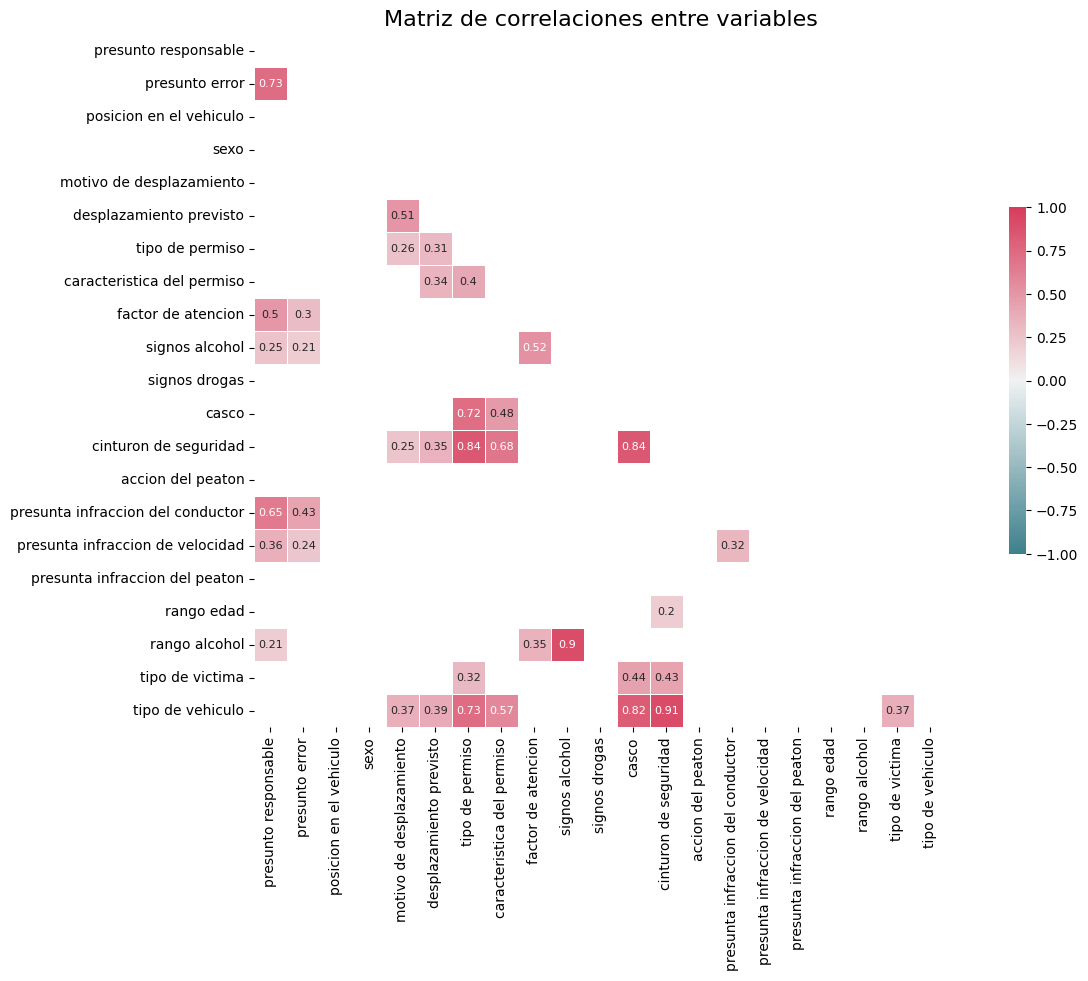

In [20]:
plot_correlation_heatmap(corr_matrix, "Matriz de correlaciones entre variables")

### Analizamos las víctimas mortales

In [21]:
df_cond_mortal = df_conductores[df_conductores['tipo de victima'] == "victima mortal"]

In [22]:
df_cond_mortal = df_cond_mortal.drop(columns = "tipo de victima")

In [23]:
encoder = OneHotEncoder(drop = "if_binary", sparse_output = False)
mortal_encoded = encoder.fit_transform(df_cond_mortal)

df_mortal_encoded = pd.DataFrame(mortal_encoded, columns=encoder.get_feature_names_out(df_cond_mortal.columns))

In [24]:
df_mortal_encoded.head()

,presunto responsable_SÍ,presunto error_Ejecución incorrecta de maniobra o maniobra inadecuada,"presunto error_Indecisión, demora o retraso en tomar una decisión",presunto error_No se aprecian errores,presunto error_No ver un vehículo/peatón/obstáculo...,presunto error_Se desconoce,posicion en el vehiculo_Se desconoce,sexo_Mujer,motivo de desplazamiento_Actividad deportiva particular,"motivo de desplazamiento_Bomberos, Policía, Ambulancia",...,rango edad_De 45 a 64 años,rango edad_De 65 a 74 años,rango edad_Más de 74 años,rango alcohol_No prueba/no positivo,tipo de vehiculo_bicicleta,tipo de vehiculo_camion,tipo de vehiculo_furgoneta,tipo de vehiculo_maquinaria obra agricola,tipo de vehiculo_motocicleta,tipo de vehiculo_turismo
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Modelo con librería PRINCE

In [25]:
import prince

mca = prince.MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(df_mortal_encoded)

In [26]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.112,12.29%,12.29%
1,0.110,12.08%,24.38%


In [27]:
mca.plot(
    df_mortal_encoded,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

In [28]:
coord = mca.row_coordinates(df_mortal_encoded)

In [29]:
from sklearn.cluster import SpectralClustering

import numpy as np

clustering = SpectralClustering(n_clusters=3,
                                assign_labels='discretize',
                                random_state=42).fit(coord)

In [30]:
# Obtener las etiquetas de los clusters
labels = clustering.labels_

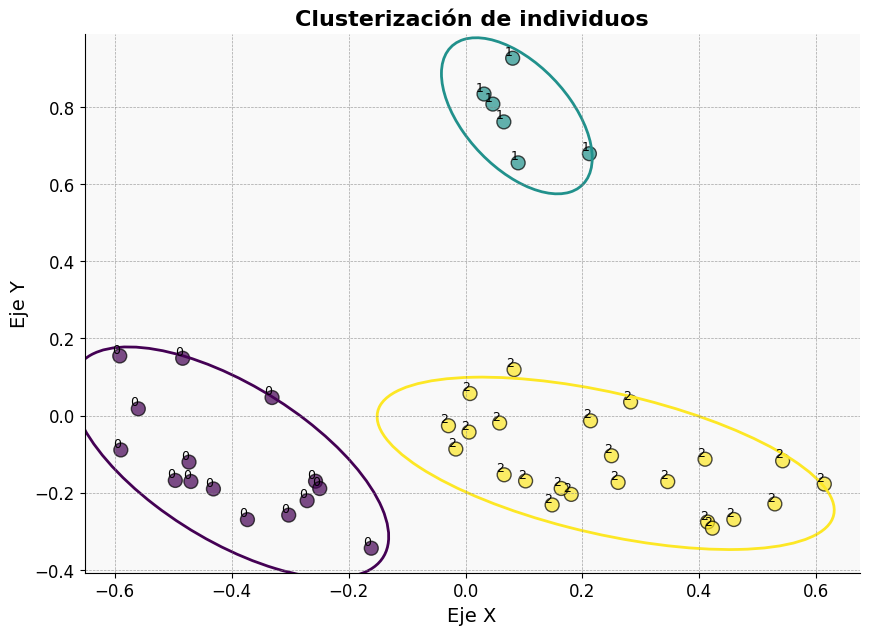

In [31]:
plot_cluster_scatter(coord, labels, "Clusterización de individuos")

In [32]:
# Contar cuántos puntos hay en cada cluster
counts = np.bincount(labels)
print("Puntos en cada cluster:", counts)

Puntos en cada cluster: [15  6 23]


### Analizamos las víctimas graves

In [33]:
df_cond_grave = df_conductores[df_conductores['tipo de victima'] == "victima grave"]

In [34]:
df_cond_grave = df_cond_grave.drop(columns = "tipo de victima")

In [35]:
encoder = OneHotEncoder(drop = "if_binary", sparse_output = False)
grave_encoded = encoder.fit_transform(df_cond_grave)

df_grave_encoded = pd.DataFrame(grave_encoded, columns=encoder.get_feature_names_out(df_cond_grave.columns))

In [36]:
import prince

mca = prince.MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(df_grave_encoded)

In [37]:
mca.plot(
    df_grave_encoded,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

### Analizamos todo tipo de víctimas y vehículos

In [38]:
encoder = OneHotEncoder(drop = "if_binary", sparse_output = False)
cond_encoded = encoder.fit_transform(df_conductores)

df_cond_encoded = pd.DataFrame(cond_encoded, columns=encoder.get_feature_names_out(df_conductores.columns))

In [39]:
df_cond_encoded.head()

,presunto responsable_NO,presunto responsable_Se desconoce,presunto responsable_SÍ,presunto error_Ejecución incorrecta de maniobra o maniobra inadecuada,"presunto error_Indecisión, demora o retraso en tomar una decisión",presunto error_No entender una señal de tráfico o confundirla,presunto error_No se aprecian errores,presunto error_No ver un vehículo/peatón/obstáculo...,presunto error_No ver una señal,"presunto error_Olvidos (intermitentes, luces...)",...,tipo de victima_victima grave,tipo de victima_victima leve,tipo de victima_victima mortal,tipo de vehiculo_bicicleta,tipo de vehiculo_camion,tipo de vehiculo_furgoneta,tipo de vehiculo_maquinaria obra agricola,tipo de vehiculo_motocicleta,tipo de vehiculo_otro,tipo de vehiculo_turismo
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
import prince

mca = prince.MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(df_cond_encoded)

In [41]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [42]:
mca.plot(
    df_cond_encoded,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

## Datos de vías y tramos junto con accidentes

### Datos de accidentes totales

In [43]:
columns_del_acc = ['fecha del accidente', 'longitud', 'latitud', 'factores concurrentes', "salida de via",
                   'descripcion del accidente', 'dia semana orden']

drop_columns_df(df_accidentes, columns_del_acc)

In [44]:
columns_del_vias = ['carriles ascendente', 'carriles descendente']

drop_columns_df(df_vias, columns_del_vias)

In [45]:
columns_del_tramos = ['tipo calzada', 'imd']

drop_columns_df(df_tramos, columns_del_tramos)

In [46]:
df_acc = df_accidentes.merge(df_vias, how ="left", on = "codigo del accidente")

In [47]:
df_acc = df_acc.merge(df_tramos, how ="outer", on = "codigo del accidente")

In [48]:
df_acc = df_acc.drop(columns = "codigo del accidente", axis = 1)

In [49]:
df_acc.isna().sum()

total personas                        0
total victimas                        0
victimas mortales                     0
victimas graves                       0
victimas leves                        0
ilesos                                0
se desconoce                          0
carretera en informe                  0
sentido                               0
zona                                  0
municipio                             0
tipo de via                           0
tipo de nudo                          0
informacion de nudo                   0
tipo de accidente                     0
suceso                                0
sentido contrario                     0
viento fuerte                         0
estado meteorologico                  0
iluminacion                           0
superficie firme                      0
tipo de dia                           0
hora                                  0
mes                                   0
dia semana                            0


### Categorizamos las variables numéricas para simplificar el cálculo

In [50]:
numeric_cols = df_acc.select_dtypes(['number']).columns
numeric_cols

Index(['total personas', 'total victimas', 'victimas mortales',
       'victimas graves', 'victimas leves', 'ilesos', 'se desconoce', 'hora',
       'mes', 'limite velocidad'],
      dtype='object')

In [51]:
df_acc['rango_personas'] = df_acc['total personas'].apply(asignar_rango_personas)

In [52]:
df_acc['rango_victimas'] = df_acc['total victimas'].apply(asignar_rango_victimas)

In [53]:
df_acc['rango_horas'] = df_acc['hora'].apply(asignar_rango_horas)

In [54]:
df_acc['rango_velocidad'] = df_acc['limite velocidad'].apply(asignar_rango_velocidad)

In [55]:
df_acc['tipo_victima'] = df_acc.apply(asignar_tipo_victima_2, axis=1)

In [56]:
columns_delete = ['total personas', 'total victimas', 'victimas mortales', 'hora',
                  'victimas graves', 'victimas leves', 'ilesos', 'se desconoce',
                  'carretera en informe', 'municipio', "limite velocidad",
                  "marcas viales", "elementos de separacion", "elementos de balizamiento",
                  "tipo de elementos de tramo", "caracteristica funcional de la via"]

drop_columns_df(df_acc, columns_delete)

In [57]:
df_acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4251 entries, 0 to 4250
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   sentido                    4251 non-null   object
 1   zona                       4251 non-null   object
 2   tipo de via                4251 non-null   object
 3   tipo de nudo               4251 non-null   object
 4   informacion de nudo        4251 non-null   object
 5   tipo de accidente          4251 non-null   object
 6   suceso                     4251 non-null   object
 7   sentido contrario          4251 non-null   object
 8   viento fuerte              4251 non-null   object
 9   estado meteorologico       4251 non-null   object
 10  iluminacion                4251 non-null   object
 11  superficie firme           4251 non-null   object
 12  tipo de dia                4251 non-null   object
 13  mes                        4251 non-null   int64 
 14  dia sema

### Analizamos los accidentes con víctimas mortales

In [58]:
df_acc["tipo_victima"].unique()

array(['se desconoce', 'victima leve', 'victima grave', 'victima mortal',
       'ileso'], dtype=object)

In [59]:
df_acc_mortal = df_acc[df_acc['tipo_victima'] == "victima mortal"]

In [60]:
df_acc_mortal = df_acc_mortal.drop(columns = "tipo_victima", axis = 1)

In [61]:
encoder = OneHotEncoder(drop = "if_binary", sparse_output = False)
acc_encoded = encoder.fit_transform(df_acc_mortal)

df_acc_mort_encoded = pd.DataFrame(acc_encoded, columns=encoder.get_feature_names_out(df_acc_mortal.columns))

In [62]:
df_acc_mort_encoded.head()

,sentido_Ascendente,sentido_Descendente,sentido_Mixto,sentido_Se Ignora,zona_Travesia,tipo de via_Calle,tipo de via_Carretera convencional de calzada única,tipo de via_Carretera convencional de doble calzada,tipo de nudo_Fuera de nudo o de su zona de influencia (>20m / >200m),informacion de nudo_En T o Y,...,rango_victimas_Menos de 3,rango_horas_Entre las 00 y las 6,rango_horas_Entre las 11 y las 14,rango_horas_Entre las 15 y las 17,rango_horas_Entre las 18 y las 21,rango_horas_Entre las 22 y las 00,rango_horas_Entre las 7 y las 10,rango_velocidad_Entre 30 y 60 km/h,rango_velocidad_Entre 60 y 90 km/h,rango_velocidad_Hasta 30 Km/h
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### Modelo con librería PRINCE

In [63]:
import prince

mca = prince.MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(df_acc_mort_encoded)

In [64]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.104,10.73%,10.73%
1,0.067,6.88%,17.61%


In [65]:
mca.plot(
    df_acc_mort_encoded,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

### Analizamos los accidentes con todo tipo de víctima

In [66]:
encoder = OneHotEncoder(drop = "if_binary", sparse_output = False)
acc_encoded = encoder.fit_transform(df_acc)

df_acc_encoded = pd.DataFrame(acc_encoded, columns=encoder.get_feature_names_out(df_acc.columns))

In [67]:
df_acc_encoded

,sentido_Ascendente,sentido_Descendente,sentido_Mixto,sentido_Se Ignora,zona_Calle,zona_Carretera,zona_Travesia,tipo de via_Autopista de peaje,tipo de via_Autovía,tipo de via_Calle,...,rango_horas_Entre las 7 y las 10,rango_velocidad_Entre 30 y 60 km/h,rango_velocidad_Entre 60 y 90 km/h,rango_velocidad_Hasta 30 Km/h,rango_velocidad_Limite de 120 km/h,tipo_victima_ileso,tipo_victima_se desconoce,tipo_victima_victima grave,tipo_victima_victima leve,tipo_victima_victima mortal
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4246,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4247,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4248,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4249,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [68]:
mca = prince.MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(df_acc_encoded)

In [69]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.043,4.28%,4.28%
1,0.035,3.47%,7.74%


In [70]:
mca.plot(
    df_acc_encoded,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

## Datos de vías y vehículos

In [71]:
# Nos centraremos simplemente en los conductores
mask_conductores = df_personas["posicion"] == "Conductor"

df_cond_vias = df_personas[mask_conductores]

In [72]:
df_cond_vias = df_cond_vias.dropna()

In [73]:
lista_del_cols = ["identificador", "vehiculo", "posicion", "edad", "tasa de alcohol 1"]

drop_columns_df(df_cond_vias, lista_del_cols)

In [74]:
df_id_cond = df_cond_vias["codigo del accidente"]

In [75]:
df_cond_vias = df_cond_vias.drop("codigo del accidente", axis = 1)

In [76]:
numeric_cols = df_cond_vias.select_dtypes(['number']).columns
numeric_cols

Index(['bicicleta', 'camion', 'furgoneta', 'maquinaria obra agricola',
       'motocicleta', 'turismo', 'vmp', 'otro'],
      dtype='object')

In [77]:
vehicle_columns = numeric_cols
df_cond_vias = agrupar_vehiculo(df_cond_vias, vehicle_columns)

In [78]:
df_cond_vias["codigo del accidente"] = df_id_cond

In [79]:
df_cond_vias.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5611 entries, 0 to 7655
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   presunto responsable               5611 non-null   object
 1   presunto error                     5611 non-null   object
 2   posicion en el vehiculo            5611 non-null   object
 3   sexo                               5611 non-null   object
 4   motivo de desplazamiento           5611 non-null   object
 5   desplazamiento previsto            5611 non-null   object
 6   tipo de permiso                    5611 non-null   object
 7   caracteristica del permiso         5611 non-null   object
 8   factor de atencion                 5611 non-null   object
 9   signos alcohol                     5611 non-null   object
 10  signos drogas                      5611 non-null   object
 11  casco                              5611 non-null   object
 12  cinturon de

- Cargamos y limpiamos el dataframe de características de las vías

In [80]:
df_vias['rango_velocidad'] = df_vias['limite velocidad'].apply(asignar_rango_velocidad)

In [81]:
df_vias.columns

Index(['codigo del accidente', 'numero de calzadas', 'ancho carril', 'arcen',
       'limite velocidad', 'sentidos', 'marcas viales', 'trazado en alzado',
       'trazado en planta', 'elementos de separacion',
       'elementos de balizamiento', 'tipo de elementos de tramo',
       'circunstancias especiales', 'caracteristica funcional de la via',
       'rango_velocidad'],
      dtype='object')

In [82]:
lista_del_cols = ['marcas viales', 'elementos de separacion', 'elementos de balizamiento',
                  'tipo de elementos de tramo', "limite velocidad"]

drop_columns_df(df_vias, lista_del_cols)

In [83]:
df_vias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4138 entries, 0 to 4137
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   codigo del accidente                4138 non-null   int64 
 1   numero de calzadas                  4138 non-null   object
 2   ancho carril                        4138 non-null   object
 3   arcen                               4138 non-null   object
 4   sentidos                            4138 non-null   object
 5   trazado en alzado                   4138 non-null   object
 6   trazado en planta                   4138 non-null   object
 7   circunstancias especiales           4138 non-null   object
 8   caracteristica funcional de la via  4138 non-null   object
 9   rango_velocidad                     4138 non-null   object
dtypes: int64(1), object(9)
memory usage: 323.4+ KB


In [84]:
df_cond_vias = df_cond_vias.merge(df_vias, how ="left", on = "codigo del accidente")

In [85]:
df_cond_vias = df_cond_vias.drop(columns = "codigo del accidente", axis = 1)

In [86]:
df_cond_vias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   presunto responsable                5611 non-null   object
 1   presunto error                      5611 non-null   object
 2   posicion en el vehiculo             5611 non-null   object
 3   sexo                                5611 non-null   object
 4   motivo de desplazamiento            5611 non-null   object
 5   desplazamiento previsto             5611 non-null   object
 6   tipo de permiso                     5611 non-null   object
 7   caracteristica del permiso          5611 non-null   object
 8   factor de atencion                  5611 non-null   object
 9   signos alcohol                      5611 non-null   object
 10  signos drogas                       5611 non-null   object
 11  casco                               5611 non-null   obje

In [87]:
encoder = OneHotEncoder(drop = "if_binary", sparse_output = False)
cond_vias_encoded = encoder.fit_transform(df_cond_vias)

df_cond_vias_encoded = pd.DataFrame(cond_vias_encoded, columns=encoder.get_feature_names_out(df_cond_vias.columns))

In [88]:
df_cond_vias_encoded

,presunto responsable_NO,presunto responsable_Se desconoce,presunto responsable_SÍ,presunto error_Ejecución incorrecta de maniobra o maniobra inadecuada,"presunto error_Indecisión, demora o retraso en tomar una decisión",presunto error_No entender una señal de tráfico o confundirla,presunto error_No se aprecian errores,presunto error_No ver un vehículo/peatón/obstáculo...,presunto error_No ver una señal,"presunto error_Olvidos (intermitentes, luces...)",...,caracteristica funcional de la via_Circunvalación,caracteristica funcional de la via_Ninguna de las anteriores,caracteristica funcional de la via_Otra zona de especial regulación,caracteristica funcional de la via_Zona a 30,caracteristica funcional de la via_Zona peatonal,caracteristica funcional de la via_Zona periurbana,rango_velocidad_Entre 30 y 60 km/h,rango_velocidad_Entre 60 y 90 km/h,rango_velocidad_Hasta 30 Km/h,rango_velocidad_Limite de 120 km/h
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5606,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5607,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5608,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5609,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [89]:
mca = prince.MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(df_cond_vias_encoded)

In [90]:
mca.plot(
    df_cond_vias_encoded,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)